Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
# Importing libraries
from glob import glob
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from pathlib import Path
import pathlib

In [4]:

data_dir_train = pathlib.Path("/content/gdrive/My Drive/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Test")
base_path = "/content/gdrive/MyDrive/"


In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2248
118


# Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.
# Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds  = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset = 'training',
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 2248 files belonging to 9 classes.
Using 1799 files for training.


Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2248 files belonging to 9 classes.
Using 449 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Visualize the data


In [10]:
# Image Rescaling. The 1./255 is to convert from unit8 to float32 in range[0, 1]
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data_gen = image_generator.flow_from_directory(directory=data_dir_train,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    target_size=(img_height, img_width),
                                                    classes=list(class_names),
                                                    class_mode='categorical')

Found 2248 images belonging to 9 classes.


In [11]:
import matplotlib.pyplot as plt
def show_image(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(9):
        ax = plt.subplot(3, 3, n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')


       

tf.Tensor([4 3 1 5 3 4 3 4 4 2 4 3 4 5 8 3 4 8 7 5 5 3 1 7 5 5 5 6 3 3 3 8], shape=(32,), dtype=int32)


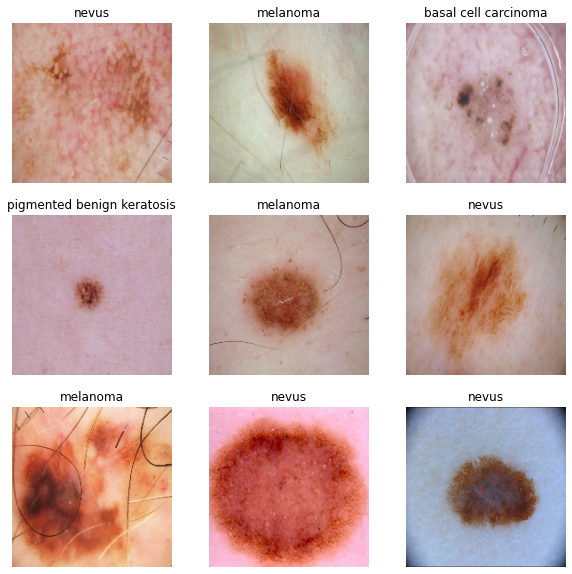

In [12]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  print(labels)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.


In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the CNN Model


In [14]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')
])


In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
model.build


<bound method Sequential.build of <keras.engine.sequential.Sequential object at 0x7fd9b6029590>>

# Train the model


In [17]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 216s 1s/step - loss: 2.1073 - accuracy: 0.2518 - val_loss: 1.8591 - val_accuracy: 0.2650
Epoch 2/20
57/57 [==============================] - 5s 80ms/step - loss: 1.7585 - accuracy: 0.3602 - val_loss: 1.6986 - val_accuracy: 0.4143
Epoch 3/20
57/57 [==============================] - 5s 79ms/step - loss: 1.5684 - accuracy: 0.4486 - val_loss: 1.5008 - val_accuracy: 0.4699
Epoch 4/20
57/57 [==============================] - 5s 80ms/step - loss: 1.4232 - accuracy: 0.4997 - val_loss: 1.3721 - val_accuracy: 0.5278
Epoch 5/20
57/57 [==============================] - 5s 79ms/step - loss: 1.3188 - accuracy: 0.5381 - val_loss: 1.3959 - val_accuracy: 0.5033
Epoch 6/20
57/57 [==============================] - 5s 79ms/step - loss: 1.3164 - accuracy: 0.5303 - val_loss: 1.4431 - val_accuracy: 0.4677
Epoch 7/20
57/57 [==============================] - 4s 79ms/step - loss: 1.2071 - accuracy: 0.5770 - val_loss: 1.4409 - val_accuracy: 0.5145
Epoch 8/20
57

In [19]:
# View the summary of all layers
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

# Visualizing training results

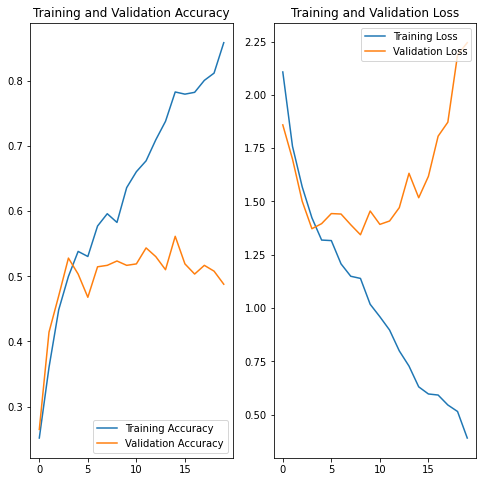

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

ote: It is clearly evident from above that the model shows overfitting.

There are two observations to justify overfitting:


1.   After 20 epochs, we could see that validation losses are higher than training losses, and also validation accuracy drastically reduced compared to training accuracy

  

      *   Training loss: 0.3903 Vs Validation loss: 2.2446
      *  Training accuracy: 0.8583 Vs Validation accuracy: 0.4878


  


2.   The above Graph shows difference in the training and validation w.r.t accuracy and losses.



# Augmentation Strategy


In [21]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

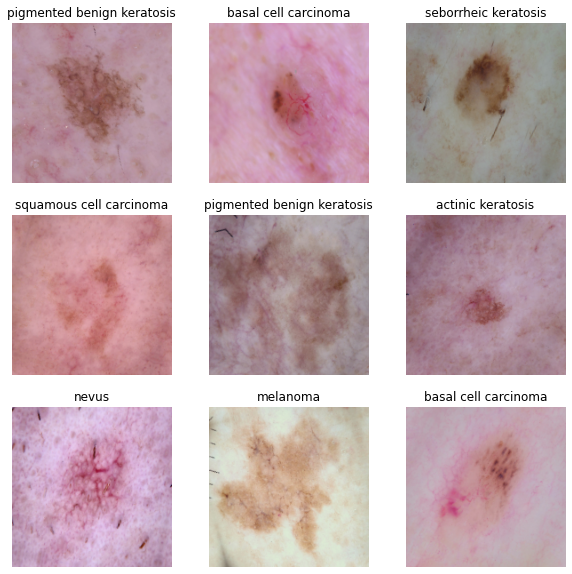

In [22]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(images[i], 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

# Create the model, compile and train the model



In [23]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.15),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')
])


In [24]:
## Your code goes here
model.compile(optimizer='adam',
              # loss='sparse_categorical_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
## Your code goes here, note: train your model for 20 epochs

history =  model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


57/57 [==============================] - 6s 89ms/step - loss: 2.0480 - accuracy: 0.2479 - val_loss: 1.8635 - val_accuracy: 0.2918
Epoch 2/20
57/57 [==============================] - 5s 84ms/step - loss: 1.7128 - accuracy: 0.3624 - val_loss: 1.7696 - val_accuracy: 0.3853
Epoch 3/20
57/57 [==============================] - 5s 84ms/step - loss: 1.5702 - accuracy: 0.4591 - val_loss: 1.4898 - val_accuracy: 0.4855
Epoch 4/20
57/57 [==============================] - 5s 84ms/step - loss: 1.4401 - accuracy: 0.4880 - val_loss: 1.4470 - val_accuracy: 0.5078
Epoch 5/20
57/57 [==============================] - 5s 85ms/step - loss: 1.3609 - accuracy: 0.5231 - val_loss: 1.3959 - val_accuracy: 0.5234
Epoch 6/20
57/57 [==============================] - 5s 84ms/step - loss: 1.3933 - accuracy: 0.5147 - val_loss: 1.7251 - val_accuracy: 0.4454
Epoch 7/20
57/57 [==============================] - 5s 84ms/step - loss: 1.2921 - accuracy: 0.5370 - val_loss: 1.2897 - val_accuracy: 0.5323
Epoch 8/20
57/57 [======

##Visualising the results


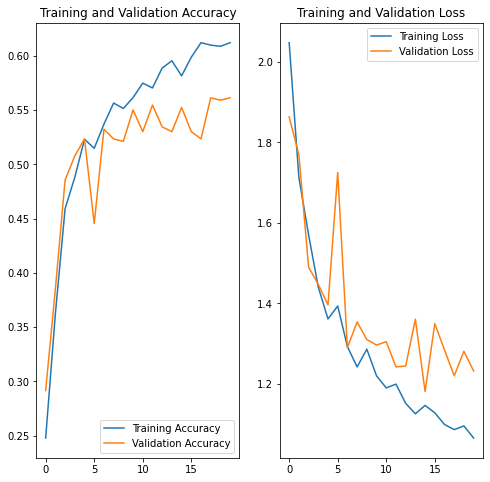

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As per the above model 2 result, the current model is not overfit, and it performs better than previous model after adding Augumentation strategy and dropout method.

Please find the training and validation accuracy:

*   The training accuracy: 0.6120 & validation accuracy: 0.5612
*   The training loss: 1.0649 & validation loss: 1.2315 





#Find the distribution of classes in the training dataset.

**Context**: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
## Your code goes here.
total_image_count = len(list(data_dir_train.glob('**/*/*.jpg')))
perc_class = {}
for name in class_names:
    perc_class[name] = round((len(list(data_dir_train.glob('{0}/*.jpg'.format(name)))) / total_image_count)*100,2)
df = pd.DataFrame(list(perc_class.items()), columns=['Class', 'Distribution Percentage'])

df

,Class,Distribution Percentage
0,actinic keratosis,5.07
1,basal cell carcinoma,16.73
2,dermatofibroma,4.23
3,melanoma,19.48
4,nevus,16.28
5,pigmented benign keratosis,20.55
6,seborrheic keratosis,3.43
7,squamous cell carcinoma,8.05
8,vascular lesion,6.18


In [28]:
# Get the distribution of data for each class
total_count = 0
data_dict = {}
for name in class_names:
    data_dict[name] = len(list(data_dir_train.glob('{0}/*.jpg'.format(name))))
    total_count += len(list(data_dir_train.glob('{0}/*.jpg'.format(name))))


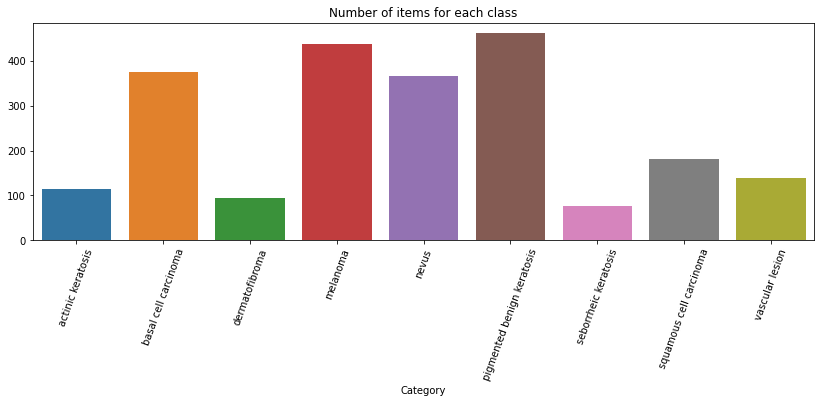

In [29]:
# Plot the distribution of data using bar plot
f, ax = plt.subplots(1,1, figsize=(14,4))
g = sns.barplot(x=list(data_dict.keys()), y = list(data_dict.values()))
g.set_title("Number of items for each class")
g.set_xlabel("Category")
plt.xticks(rotation=70)
plt.show()

#Write your findings here:
- Which class has the least number of samples?
  **seborrheic keratosis** has least number of samples -  
- Which classes dominate the data in terms proportionate number of samples?
  **pigmented benign keratosis** has  the highest number of samples

# Rectify the clss imbalance

In [30]:
!pip install Augmentor


In [31]:
path_to_training_dataset ="/content/gdrive/MyDrive/Train/"
# data_dir_train = pathlib.Path(root_path + '/Train')
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i )
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD93D0B5390>: 100%|██████████| 500/500 [00:25<00:00, 19.54 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD93D0999D0>: 100%|██████████| 500/500 [00:30<00:00, 16.37 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD93D3C82D0>: 100%|██████████| 500/500 [00:31<00:00, 15.63 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7FD93CFF6E50>: 100%|██████████| 500/500 [01:47<00:00,  4.67 Samples/s]


Initialised with 366 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD93D0999D0>: 100%|██████████| 500/500 [01:41<00:00,  4.93 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD938891850>: 100%|██████████| 500/500 [00:23<00:00, 20.89 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD93D119810>: 100%|██████████| 500/500 [00:52<00:00,  9.51 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD9B6288690>: 100%|██████████| 500/500 [00:23<00:00, 21.72 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD93895F790>: 100%|██████████| 500/500 [00:23<00:00, 20.98 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
# Get the total number of samples newly added using Augumentor
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)



4500


#Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
# Get the list of paths that originally had without Augumentor

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031243.jpg_d1160495-fd52-4c31-afc6-8417c7444612.jpg',
 '/content/gdrive/My Drive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026213.jpg_b0b337e0-e5e2-49a8-b168-66efebbd4f73.jpg',
 '/content/gdrive/My Drive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031552.jpg_2889c201-1e71-484b-95e3-3fdff5f44275.jpg',
 '/content/gdrive/My Drive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025644.jpg_5240e214-b8fc-4627-9532-76d6e427db29.jpg',
 '/content/gdrive/My Drive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028570.jpg_75b772a0-1077-46db-9f45-d21dfc482972.jpg',
 '/content/gdrive/My Drive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025731.jpg_fbf8fb55-8951-40c4-8c33-50bbf9660597.jpg',
 '/content/gdrive/My Drive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISI

In [34]:
# Get the class names for each paths of original data


lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))


In [36]:
df1 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
len(df1)


4500

In [37]:
# Create a dataframe using newly added data using Augumentor
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# Merge orginal data with newly added data
new_df = df1.append(df2)

In [38]:
# Get the list of paths that new added using Augumentor
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031243.jpg_d1160495-fd52-4c31-afc6-8417c7444612.jpg',
 '/content/gdrive/My Drive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026213.jpg_b0b337e0-e5e2-49a8-b168-66efebbd4f73.jpg',
 '/content/gdrive/My Drive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031552.jpg_2889c201-1e71-484b-95e3-3fdff5f44275.jpg',
 '/content/gdrive/My Drive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025644.jpg_5240e214-b8fc-4627-9532-76d6e427db29.jpg',
 '/content/gdrive/My Drive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028570.jpg_75b772a0-1077-46db-9f45-d21dfc482972.jpg',
 '/content/gdrive/My Drive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025731.jpg_fbf8fb55-8951-40c4-8c33-50bbf9660597.jpg',
 '/content/gdrive/My Drive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISI

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df =df2

In [40]:
new_df['Label'].value_counts()


basal cell carcinoma          500
vascular lesion               500
dermatofibroma                500
melanoma                      500
actinic keratosis             500
squamous cell carcinoma       500
seborrheic keratosis          500
pigmented benign keratosis    500
nevus                         500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#Train the model on the data created using Augmentor

In [41]:

batch_size = 32
img_height = 180
img_width = 180

#Create a Training Data Set

In [42]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset =  'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6748 files belonging to 9 classes.
Using 5399 files for training.


#Create a Validation Data Set


In [43]:


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6748 files belonging to 9 classes.
Using 1349 files for validation.


#Create your model (make sure to include normalization)

In [44]:
## your code goes here
model = Sequential([

    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    

    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(9, activation='softmax')
])

#Compile the model

In [45]:

## your code goes here
model.compile(optimizer='adam',
              # loss='sparse_categorical_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Train the Model

In [49]:
epochs = 30
## Your code goes here, use 30 epochs.
history =  model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 44s 241ms/step - loss: 0.2686 - accuracy: 0.8931 - val_loss: 0.5993 - val_accuracy: 0.7910
Epoch 2/30
169/169 [==============================] - 44s 254ms/step - loss: 0.2555 - accuracy: 0.8981 - val_loss: 0.8311 - val_accuracy: 0.7709
Epoch 3/30
169/169 [==============================] - 41s 236ms/step - loss: 0.2499 - accuracy: 0.8961 - val_loss: 0.4670 - val_accuracy: 0.8377
Epoch 4/30
169/169 [==============================] - 41s 237ms/step - loss: 0.2431 - accuracy: 0.9000 - val_loss: 0.7760 - val_accuracy: 0.7598
Epoch 5/30
169/169 [==============================] - 42s 238ms/step - loss: 0.2634 - accuracy: 0.8950 - val_loss: 1.7165 - val_accuracy: 0.5656
Epoch 6/30
169/169 [==============================] - 41s 236ms/step - loss: 0.2613 - accuracy: 0.8965 - val_loss: 0.4692 - val_accuracy: 0.8317
Epoch 7/30
169/169 [==============================] - 41s 237ms/step - loss: 0.2467 - accuracy: 0.9004 - val_loss: 0.7035 - val_ac

#Visualise the Model results






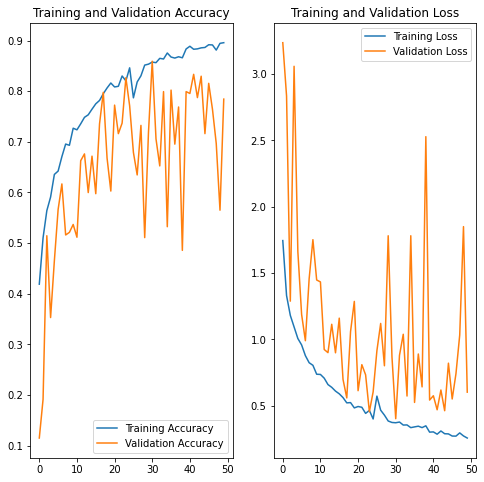

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Summary:
1. The above model shows that model is not overfit. This is because, we were able to resolve the class rebalance issue by adding more samples of images using Augumentor.
2. The model is able to predict well by using multiple layers of Convolution 2D (Upto 256).
3. Further, the model is able to generalize well by using Batch Normalization in multiple layers.
4. In addition to the above, dropout (0.5) has been added to generalize the model.
5. The training accuracy has improved with a value of  0.9105 whereas validation accuracy is now 0.8295
6. The training loss is reduced to 0.2182  and validation loss is reduced to 0.4978
7. The model can be further improved by adding more images.
